# Explicit Feedback Neural Recommender Systems

Goals:
- Understand recommender data
- Build different models architectures using Tensorflow
- Retrieve Embeddings and visualize them
- Add metadata information as input to the model

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.python.estimator.inputs import numpy_io
from tensorflow.contrib.learn import *
%matplotlib inline 

In [4]:
print('Tensorflow Version : {0}'.format(tf.__version__))

Tensorflow Version : 1.5.0


### Ratings file

Each line contains a rated movie: 
- a user
- an item
- a rating from 1 to 5 stars

In [5]:
# Base Path for MovieLens dataset
ML_100K_PATH = os.path.join('processed','ml-100k','ml-100k')

In [6]:
df_raw_ratings = pd.read_csv(os.path.join(ML_100K_PATH, 'u.data'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])
df_raw_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Item metadata file


In [7]:
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
# Loading only 5 columns
df_items = pd.read_csv(os.path.join(ML_100K_PATH, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
df_items.head()

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [8]:
def get_release_year(x):
    splits = str(x).split('-')
    if(len(splits) == 3):
        return int(splits[2])
    else:
        return 1920
    
df_items['release_year'] = df_items['release_date'].map(lambda x : get_release_year(x))

In [9]:
df_items.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,1995
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,1995
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,1995
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),1995


## Merge Rating with Item Metadata

In [10]:
df_all_ratings = pd.merge(df_items, df_raw_ratings)

In [11]:
df_all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


## Data Preprocessing

To understand well the distribution of the data, the following statistics are computed:
- the number of users
- the number of items
- the rating distribution
- the popularity of each movie

In [12]:
# Number of users
max_user_id = df_all_ratings['user_id'].max()
max_user_id

943

In [13]:
# Number of items
max_item_id = df_all_ratings['item_id'].max()
max_item_id

1682

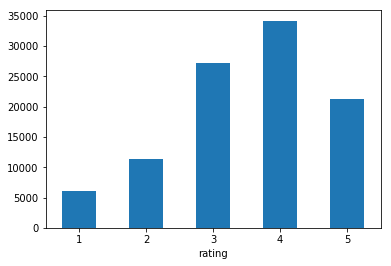

In [14]:
df_all_ratings.groupby('rating')['rating'].count().plot(kind='bar', rot=0);

In [15]:
# ratings
df_all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

### Add Popularity

In [16]:
popularity = df_all_ratings.groupby('item_id').size().reset_index(name='popularity')

Enrich the ratings data with the popularity as an additional metadata.

In [17]:
df_all_ratings = pd.merge(df_all_ratings, popularity)
df_all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp,popularity
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532,452
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088,452
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411,452
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426,452
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324,452


In [18]:
df_all_ratings.nlargest(10, 'popularity')

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp,popularity
6402,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,290,5,880473582,583
6403,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,79,4,891271545,583
6404,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,2,5,888552084,583
6405,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,8,5,879362124,583
6406,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,274,5,878944679,583
6407,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,227,4,879035347,583
6408,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,99,5,885679998,583
6409,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,305,5,886321799,583
6410,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,108,4,879879739,583
6411,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977,63,4,875747292,583


Later in the analysis we will assume that this popularity does not come from the ratings themselves but from an external metadata, e.g. box office numbers in the month after the release in movie theaters.

Let's split the enriched data in a train / test split to make it possible to do predictive modeling:

### Train Test Validation Split

In [19]:
# Split All ratings into train_val and test
ratings_train_val, ratings_test = train_test_split(df_all_ratings, test_size=0.2, random_state=0)
# Split train_val into training and validation set
ratings_train, ratings_val = train_test_split(ratings_train_val, test_size=0.2, random_state=0)

print('Total rating rows count: {0} '.format(len(df_all_ratings)))
print('Total training rows count: {0} '.format(len(ratings_train_val)))
print('Total validation rows count: {0} '.format(len(ratings_val)))
print('Total test rows count: {0} '.format(len(ratings_test)))


Total rating rows count: 100000 
Total training rows count: 80000 
Total validation rows count: 16000 
Total test rows count: 20000 


In [20]:
ratings_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64000 entries, 39110 to 59493
Data columns (total 10 columns):
item_id               64000 non-null int64
title                 64000 non-null object
release_date          63995 non-null object
video_release_date    0 non-null float64
imdb_url              63992 non-null object
release_year          64000 non-null int64
user_id               64000 non-null int64
rating                64000 non-null int64
timestamp             64000 non-null int64
popularity            64000 non-null int64
dtypes: float64(1), int64(6), object(3)
memory usage: 5.4+ MB


# Explicit feedback: supervised ratings prediction

For each pair of (user, item) try to predict the rating the user would give to the item.

This is the classical setup for building recommender systems from offline data with explicit supervision signal. 

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="./images/rec_archi_1.svg" style="width: 600px;" />

### Matrix Factorization

In [21]:
embedding_size = 30 # embedding size
reg_param = 0.01 # regularization parameter lambda
learning_rate = 0.01 # learning rate 


# create tensorflow graph
g = tf.Graph()
with g.as_default():
    
    # placeholders
    users = tf.placeholder(shape=[None], dtype=tf.int64)
    items = tf.placeholder(shape=[None], dtype=tf.int64)
    ratings = tf.placeholder(shape=[None], dtype=tf.float32)
    
    # variables
    with tf.variable_scope("embedding"):
        user_weight = tf.get_variable("user_w"
                                      , shape=[max_user_id + 1, embedding_size]
                                      , dtype=tf.float32
                                      , initializer=layers.xavier_initializer())

        item_weight = tf.get_variable("item_w"
                                       , shape=[max_item_id + 1, embedding_size]
                                       , dtype=tf.float32
                                       , initializer=layers.xavier_initializer())
    # prediction
    with tf.name_scope("inference"):
        user_embedding = tf.nn.embedding_lookup(user_weight, users)
        item_embedding = tf.nn.embedding_lookup(item_weight, items)
        pred = tf.reduce_sum(tf.multiply(user_embedding, item_embedding), 1) 
        
    # loss 
    with tf.name_scope("loss"):
        reg_loss = tf.contrib.layers.apply_regularization(layers.l2_regularizer(scale=reg_param),
                                               weights_list=[user_weight, item_weight])
        loss = tf.nn.l2_loss(pred - ratings) + reg_loss
        train_ops = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        rmse = tf.sqrt(tf.reduce_mean(tf.pow(pred - ratings, 2)))

        

In [22]:

def train_model():
    # Training 
    epochs = 1000 # number of iterations 
    losses_train = []
    losses_val = []



    with tf.Session(graph=g) as sess:
        # initializer
        sess.run(tf.global_variables_initializer())


        train_input_dict = {  users: ratings_train['user_id']
                            , items: ratings_train['item_id']
                            , ratings: ratings_train['rating']}
        val_input_dict =  {  users: ratings_val['user_id']
                            , items: ratings_val['item_id']
                            , ratings: ratings_val['rating']}

        test_input_dict =  {  users: ratings_test['user_id']
                            , items: ratings_test['item_id']
                            , ratings: ratings_test['rating']}

        def check_overfit(validation_loss):
            n = len(validation_loss)
            if n < 5:
                return False
            count = 0 
            for i in range(n-4, n):
                if validation_loss[i] < validation_loss[i-1]:
                    count += 1
                if count >=2:
                    return False
            return True

        for i in range(epochs):
            # run the training operation
            sess.run([train_ops], feed_dict=train_input_dict)

            # show intermediate results 
            if i % 5 == 0:
                loss_train = sess.run(loss, feed_dict=train_input_dict)
                loss_val = sess.run(loss, feed_dict=val_input_dict)
                losses_train.append(loss_train)
                losses_val.append(loss_val)


                # check early stopping 
                if(check_overfit(losses_val)):
                    print('overfit !')
                    break

                print("iteration : {0} train loss: {1:.3f} , valid loss {2:.3f}".format(i,loss_train, loss_val))

        # calculate RMSE on the test dataset
        print('RMSE on test dataset : {0:.4f}'.format(sess.run(rmse, feed_dict=test_input_dict)))

        plt.plot(losses_train, label='train')
        plt.plot(losses_val, label='validation')
        #plt.ylim(0, 50000)
        plt.legend(loc='best')
        plt.title('Loss');

iteration : 0 train loss: 438930.062 , valid loss 109277.359
iteration : 5 train loss: 428342.219 , valid loss 107146.875
iteration : 10 train loss: 393577.125 , valid loss 98773.469
iteration : 15 train loss: 328166.312 , valid loss 82616.328
iteration : 20 train loss: 236120.094 , valid loss 59699.676
iteration : 25 train loss: 135470.672 , valid loss 34532.391
iteration : 30 train loss: 58743.949 , valid loss 15278.002
iteration : 35 train loss: 34014.059 , valid loss 9064.328
iteration : 40 train loss: 41518.238 , valid loss 11049.119
iteration : 45 train loss: 38653.758 , valid loss 10511.042
iteration : 50 train loss: 29175.646 , valid loss 8299.431
iteration : 55 train loss: 26868.498 , valid loss 7823.235
iteration : 60 train loss: 27870.803 , valid loss 8115.861
iteration : 65 train loss: 27119.334 , valid loss 7932.005
iteration : 70 train loss: 25656.236 , valid loss 7557.805
iteration : 75 train loss: 25252.391 , valid loss 7460.077
iteration : 80 train loss: 25254.188 , va

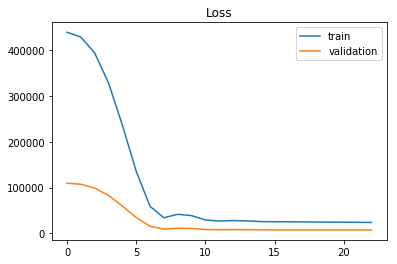

In [23]:
train_model()

### Matrix Factorization with Biases

In [24]:
embedding_size = 30 # embedding size
reg_param = 0.01 # regularization parameter lambda
learning_rate = 0.01 # learning rate 


# create tensorflow graph
g = tf.Graph()
with g.as_default():
    
    # placeholders
    users = tf.placeholder(shape=[None], dtype=tf.int64)
    items = tf.placeholder(shape=[None], dtype=tf.int64)
    ratings = tf.placeholder(shape=[None], dtype=tf.float32)
    
    # variables
    with tf.variable_scope("embedding"):
        user_weight = tf.get_variable("user_w"
                                      , shape=[max_user_id + 1, embedding_size]
                                      , dtype=tf.float32
                                      , initializer=layers.xavier_initializer())

        item_weight = tf.get_variable("item_w"
                                       , shape=[max_item_id + 1, embedding_size]
                                       , dtype=tf.float32
                                       , initializer=layers.xavier_initializer())
        
        user_bias = tf.get_variable("user_b"
                                , shape=[max_user_id + 1]
                                , dtype=tf.float32
                                , initializer=tf.zeros_initializer)
        
        item_bias = tf.get_variable("item_b"
                                 , shape=[max_item_id + 1]
                                 , dtype=tf.float32
                                 , initializer=tf.zeros_initializer)
        
    # prediction
    with tf.name_scope("inference"):
        user_embedding = tf.nn.embedding_lookup(user_weight, users)
        item_embedding = tf.nn.embedding_lookup(item_weight, items)
        user_b = tf.nn.embedding_lookup(user_bias, users)
        item_b = tf.nn.embedding_lookup(item_bias, items)
        pred = tf.reduce_sum(tf.multiply(user_embedding, item_embedding), 1) + user_b + item_b
        
    # loss 
    with tf.name_scope("loss"):
        reg_loss = tf.contrib.layers.apply_regularization(layers.l2_regularizer(scale=reg_param),
                                               weights_list=[user_weight, item_weight])
        loss = tf.nn.l2_loss(pred - ratings) + reg_loss
        train_ops = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        rmse = tf.sqrt(tf.reduce_mean(tf.pow(pred - ratings, 2)))

   

iteration : 0 train loss: 434443.031 , valid loss 108158.102
iteration : 5 train loss: 403310.625 , valid loss 100959.594
iteration : 10 train loss: 352983.938 , valid loss 88798.367
iteration : 15 train loss: 279575.562 , valid loss 70748.336
iteration : 20 train loss: 189368.469 , valid loss 48341.816
iteration : 25 train loss: 101200.297 , valid loss 26243.395
iteration : 30 train loss: 44439.621 , valid loss 11852.713
iteration : 35 train loss: 34335.340 , valid loss 9202.785
iteration : 40 train loss: 39744.508 , valid loss 10664.479
iteration : 45 train loss: 33295.910 , valid loss 9301.818
iteration : 50 train loss: 26589.682 , valid loss 7878.802
iteration : 55 train loss: 26060.906 , valid loss 7920.517
iteration : 60 train loss: 26325.492 , valid loss 8069.269
iteration : 65 train loss: 24986.539 , valid loss 7757.166
iteration : 70 train loss: 23757.424 , valid loss 7457.716
iteration : 75 train loss: 23427.906 , valid loss 7411.208
iteration : 80 train loss: 23118.686 , val

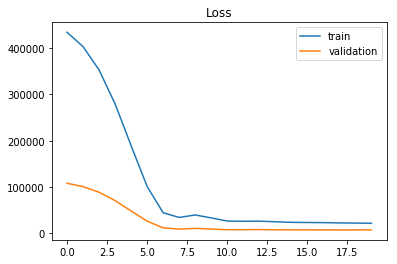

In [25]:
train_model()

## A Deep recommender model

Using a similar framework as previously, the following deep model described in the course was built (with only two fully connected)

<img src="./images/rec_archi_2.svg" style="width: 600px;" />

To build this model we will need a new kind of layer:

In [26]:
embedding_size = 30
reg_param = 0.01
learning_rate = 0.01
n_users = max_user_id + 1
n_items = max_item_id + 1

g = tf.Graph()
with g.as_default():

    users = tf.placeholder(shape=[None,1], dtype=tf.int64, name='input_users')
    items = tf.placeholder(shape=[None,1], dtype=tf.int64, name='input_items')
    ratings = tf.placeholder(shape=[None,1], dtype=tf.float32, name='input_ratings')
    
    l2_loss = tf.constant(0.0)
    
    # embeddding layer
    with tf.variable_scope("embedding"):
        user_weights = tf.get_variable("user_w"
                                      , shape=[n_users, embedding_size]
                                      , dtype=tf.float32
                                      , initializer=layers.xavier_initializer())
        
        item_weights = tf.get_variable("item_w"
                                       , shape=[n_items, embedding_size]
                                       , dtype=tf.float32
                                       , initializer=layers.xavier_initializer())
        
        user_embedding = tf.squeeze(tf.nn.embedding_lookup(user_weights, users),axis=1, name='user_embedding')
        item_embedding = tf.squeeze(tf.nn.embedding_lookup(item_weights, items),axis=1, name='item_embedding')
        
        l2_loss += tf.nn.l2_loss(user_weights)
        l2_loss += tf.nn.l2_loss(item_weights)
        
        
        print(user_embedding)
        print(item_embedding)
        
    
    # combine inputs
    with tf.name_scope('concatenation'):
        input_vecs = tf.concat([user_embedding, item_embedding], axis=1)
        print(input_vecs)
        
    # fc-1
    num_hidden = 64
    with tf.name_scope("fc_1"):
        W_fc_1 = tf.get_variable(
            "W_hidden",
            shape=[2*embedding_size, num_hidden],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="b")
        hidden_output = tf.nn.relu(tf.nn.xw_plus_b(input_vecs, W_fc_1, b_fc_1), name='hidden_output')
        l2_loss += tf.nn.l2_loss(W_fc_1)
        print(hidden_output)
        
    # dropout
    with tf.name_scope("dropout"):
        h_drop = tf.nn.dropout(hidden_output, 0.5, name="hidden_output_drop")
        print(h_drop)
    
    # fc-2
    with tf.name_scope("fc_2"):
        W_fc_2 = tf.get_variable(
            "W_output",
            shape=[num_hidden,1],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_2 = tf.Variable(tf.constant(0.1, shape=[1]), name="b")
        pred = tf.nn.xw_plus_b(h_drop, W_fc_2, b_fc_2, name='pred')
        l2_loss += tf.nn.l2_loss(W_fc_2)
        print(pred)

    # loss
    with tf.name_scope("loss"):
        loss = tf.nn.l2_loss(pred - ratings) + reg_param * l2_loss
        train_ops = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        rmse = tf.sqrt(tf.reduce_mean(tf.pow(pred - ratings, 2)))

        

Tensor("embedding/user_embedding:0", shape=(?, 30), dtype=float32)
Tensor("embedding/item_embedding:0", shape=(?, 30), dtype=float32)
Tensor("concatenation/concat:0", shape=(?, 60), dtype=float32)
Tensor("fc_1/hidden_output:0", shape=(?, 64), dtype=float32)
Tensor("dropout/hidden_output_drop/mul:0", shape=(?, 64), dtype=float32)
Tensor("fc_2/pred:0", shape=(?, 1), dtype=float32)


In [30]:
def train_model_deep():
    losses_train = []
    losses_val = []
    epochs = 1000

    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        train_input_dict = {users: ratings_train['user_id'].values.reshape([-1,1])
            , items: ratings_train['item_id'].values.reshape([-1,1])
            , ratings: ratings_train['rating'].values.reshape([-1,1])}

        val_input_dict = {users: ratings_val['user_id'].values.reshape([-1,1])
            , items: ratings_val['item_id'].values.reshape([-1,1])
            , ratings: ratings_val['rating'].values.reshape([-1,1])}

        test_input_dict = {users: ratings_test['user_id'].values.reshape([-1,1])
            , items: ratings_test['item_id'].values.reshape([-1,1])
            , ratings: ratings_test['rating'].values.reshape([-1,1])}

        def check_overfit(validation_loss):
                n = len(validation_loss)
                if n < 5:
                    return False
                count = 0 
                for i in range(n-4, n):
                    if validation_loss[i] < validation_loss[i-1]:
                        count += 1
                    if count >=2:
                        return False
                return True



        for i in range(epochs):
            sess.run([train_ops], feed_dict=train_input_dict)
            if i % 10 == 0:
                loss_train = sess.run(loss, feed_dict=train_input_dict)
                loss_val = sess.run(loss, feed_dict=val_input_dict)
                losses_train.append(loss_train)
                losses_val.append(loss_val)

                # check early stopping 
                if(check_overfit(losses_val)):
                    print('overfit !')
                    break

                print("iteration : %d train loss: %.3f , valid loss %.3f" % (i,loss_train, loss_val))

         # calculate RMSE on the test dataset
        print('RMSE on test dataset : {0:.4f}'.format(sess.run(rmse, feed_dict=test_input_dict)))

        # user and item embedding
        user_embedding_variable = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.endswith('embedding/user_w:0')][0]
        item_embedding_variable = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.endswith('embedding/item_w:0')][0]
        user_embedding_weights, item_embedding_weights = sess.run([user_embedding_variable,item_embedding_variable])
        
        
        # plot train and validation loss
        plt.plot(losses_train, label='train')
        plt.plot(losses_val, label='validation')
        #plt.ylim(0, 50000)
        plt.legend(loc='best')
        plt.title('Loss');
        
        return user_embedding_weights, item_embedding_weights 

iteration : 0 train loss: 382462.625 , valid loss 95015.547
iteration : 10 train loss: 102764.109 , valid loss 26412.195
iteration : 20 train loss: 57163.148 , valid loss 14557.842
iteration : 30 train loss: 45642.852 , valid loss 12235.200
iteration : 40 train loss: 41339.328 , valid loss 11243.003
iteration : 50 train loss: 39655.012 , valid loss 10707.484
iteration : 60 train loss: 39225.371 , valid loss 10342.282
iteration : 70 train loss: 38399.941 , valid loss 10303.009
iteration : 80 train loss: 38257.465 , valid loss 10160.244
iteration : 90 train loss: 37468.203 , valid loss 10063.709
iteration : 100 train loss: 37928.527 , valid loss 10213.989
iteration : 110 train loss: 37556.586 , valid loss 10116.717
iteration : 120 train loss: 37585.230 , valid loss 9932.123
iteration : 130 train loss: 37392.844 , valid loss 9833.561
iteration : 140 train loss: 37466.469 , valid loss 10008.520
iteration : 150 train loss: 37058.215 , valid loss 9931.349
iteration : 160 train loss: 36752.02

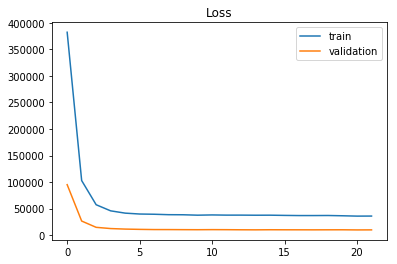

In [31]:
user_embedding_weights, item_embedding_weights  = train_model_deep()

### Model Embeddings

In [32]:
print("First item name from metadata:", df_items["title"][1])
print("Embedding vector for the first item:")
print(item_embedding_weights[1])
print("shape:", item_embedding_weights[1].shape)

First item name from metadata: GoldenEye (1995)
Embedding vector for the first item:
[ 0.08832793  0.09667744 -0.08243068 -0.10739306 -0.13265601  0.14769632
 -0.04717188 -0.08011688  0.08730887  0.08903647  0.00544227 -0.140013
  0.10530146 -0.12907408 -0.08402466  0.00859107 -0.17485157 -0.10307572
 -0.13133709 -0.09112252 -0.00481153  0.10026523 -0.12934865  0.0170101
  0.11254928 -0.14362258 -0.12560442  0.08647262 -0.08201045 -0.01445913]
shape: (30,)


### Visualizing embeddings using TSNE

- we use scikit learn to visualize items embeddings
- Try different perplexities, and visualize user embeddings as well
- What can you conclude ?

In [33]:
from sklearn.manifold import TSNE

item_tsne = TSNE(perplexity=30).fit_transform(item_embedding_weights)

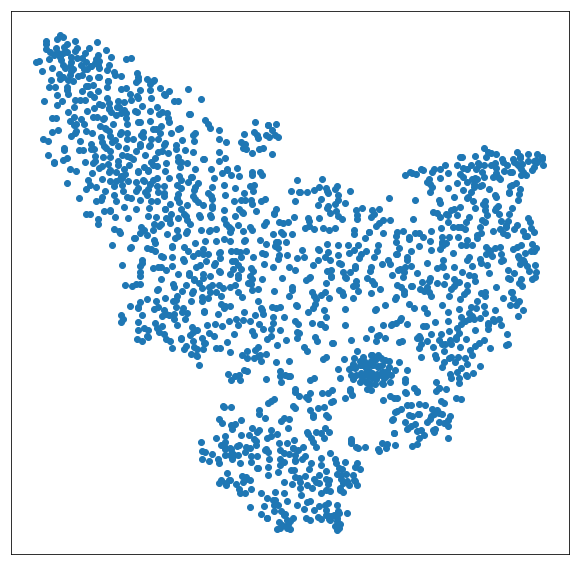

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

Alternatively with [Uniform Manifold Approximation and Projection](https://github.com/lmcinnes/umap):

In [35]:
!pip install umap-learn

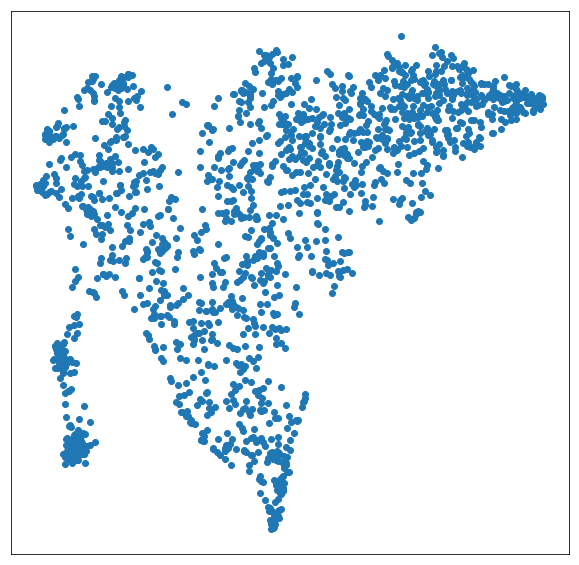

In [36]:
import umap

item_umap = umap.UMAP().fit_transform(item_embedding_weights)
plt.figure(figsize=(10, 10))
plt.scatter(item_umap[:, 0], item_umap[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

## Using item metadata in the model

Using a similar framework as previously, we will build another deep model that can also leverage additional metadata. The resulting system is therefore an **Hybrid Recommender System** that does both **Collaborative Filtering** and **Content-based recommendations**.

<img src="./images/rec_archi_3.svg" style="width: 600px;" />


In [37]:
embedding_size = 30
reg_param = 0.01
learning_rate = 0.01
n_users = max_user_id + 1
n_items = max_item_id + 1
meta_size = 2

g = tf.Graph()
with g.as_default():

    users = tf.placeholder(shape=[None,1], dtype=tf.int64, name='input_users')
    items = tf.placeholder(shape=[None,1], dtype=tf.int64, name='input_items')
    meta = tf.placeholder(shape=[None,2], dtype=tf.float32, name='input_metadata')
    ratings = tf.placeholder(shape=[None,1], dtype=tf.float32, name='input_ratings')
    
    l2_loss = tf.constant(0.0)
    
    # embeddding layer
    with tf.variable_scope("embedding"):
        user_weights = tf.get_variable("user_w"
                                      , shape=[n_users, embedding_size]
                                      , dtype=tf.float32
                                      , initializer=layers.xavier_initializer())
        
        item_weights = tf.get_variable("item_w"
                                       , shape=[n_items, embedding_size]
                                       , dtype=tf.float32
                                       , initializer=layers.xavier_initializer())
        
        
        
        user_embedding = tf.squeeze(tf.nn.embedding_lookup(user_weights, users),axis=1, name='user_embedding')
        item_embedding = tf.squeeze(tf.nn.embedding_lookup(item_weights, items),axis=1, name='item_embedding')
        
        l2_loss += tf.nn.l2_loss(user_weights)
        l2_loss += tf.nn.l2_loss(item_weights)
        
        
        print(user_embedding)
        print(item_embedding)
        
    
    # combine inputs
    with tf.name_scope('concatenation'):
        input_vecs = tf.concat([user_embedding, item_embedding, meta], axis=1)
        print(input_vecs)
        
    # fc-1
    num_hidden = 64
    with tf.name_scope("fc_1"):
        W_fc_1 = tf.get_variable(
            "W_hidden",
            shape=[2*embedding_size + meta_size, num_hidden],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="b")
        hidden_output = tf.nn.relu(tf.nn.xw_plus_b(input_vecs, W_fc_1, b_fc_1), name='hidden_output')
        l2_loss += tf.nn.l2_loss(W_fc_1)
        print(hidden_output)
    
    # dropout
    with tf.name_scope("dropout"):
        h_drop = tf.nn.dropout(hidden_output, 0.5, name="hidden_output_drop")
        print(h_drop)
    
    # fc-2
    with tf.name_scope("fc_2"):
        W_fc_2 = tf.get_variable(
            "W_output",
            shape=[num_hidden,1],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_2 = tf.Variable(tf.constant(0.1, shape=[1]), name="b")
        pred = tf.nn.xw_plus_b(h_drop, W_fc_2, b_fc_2, name='pred')
        l2_loss += tf.nn.l2_loss(W_fc_2)
        print(pred)

    # loss
    with tf.name_scope("loss"):
        loss = tf.nn.l2_loss(pred - ratings) + reg_param * l2_loss
        train_ops = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        rmse = tf.sqrt(tf.reduce_mean(tf.pow(pred - ratings, 2)))

Tensor("embedding/user_embedding:0", shape=(?, 30), dtype=float32)
Tensor("embedding/item_embedding:0", shape=(?, 30), dtype=float32)
Tensor("concatenation/concat:0", shape=(?, 62), dtype=float32)
Tensor("fc_1/hidden_output:0", shape=(?, 64), dtype=float32)
Tensor("dropout/hidden_output_drop/mul:0", shape=(?, 64), dtype=float32)
Tensor("fc_2/pred:0", shape=(?, 1), dtype=float32)


In [38]:
from sklearn.preprocessing import QuantileTransformer

meta_columns = ['popularity', 'release_year']

scaler = QuantileTransformer()
item_meta_train = scaler.fit_transform(ratings_train[meta_columns])
item_meta_val = scaler.transform(ratings_val[meta_columns])
item_meta_test = scaler.transform(ratings_test[meta_columns])

In [39]:
def train_model_deep_meta():

    losses_train = []
    losses_val = []
    epochs = 1000

    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        train_input_dict = {users: ratings_train['user_id'].values.reshape([-1,1])
            , items: ratings_train['item_id'].values.reshape([-1,1])
            , ratings: ratings_train['rating'].values.reshape([-1,1])
                           ,meta: item_meta_train}

        val_input_dict = {users: ratings_val['user_id'].values.reshape([-1,1])
            , items: ratings_val['item_id'].values.reshape([-1,1])
            , ratings: ratings_val['rating'].values.reshape([-1,1])
                         ,meta : item_meta_val}

        test_input_dict = {users: ratings_test['user_id'].values.reshape([-1,1])
            , items: ratings_test['item_id'].values.reshape([-1,1])
            , ratings: ratings_test['rating'].values.reshape([-1,1])
                          ,meta : item_meta_test}
        def check_overfit(validation_loss):
            n = len(validation_loss)
            if n < 5:
                return False
            count = 0 
            for i in range(n-4, n):
                if validation_loss[i] < validation_loss[i-1]:
                    count += 1
                if count >=2:
                    return False
            return True


        for i in range(epochs):
            sess.run([train_ops], feed_dict=train_input_dict)
            if i % 10 == 0:
                loss_train = sess.run(loss, feed_dict=train_input_dict)
                loss_val = sess.run(loss, feed_dict=val_input_dict)
                losses_train.append(loss_train)
                losses_val.append(loss_val)

                 # check early stopping 
                if(check_overfit(losses_val)):
                    print('overfit !')
                    break
                print("iteration : %d train loss: %.3f , valid loss %.3f" % (i,loss_train, loss_val))

         # calculate RMSE on the test dataset
        print('RMSE on test dataset : {0:.4f}'.format(sess.run(rmse, feed_dict=test_input_dict)))

In [40]:
train_model_deep_meta()

iteration : 0 train loss: 388502.125 , valid loss 96521.562
iteration : 10 train loss: 105616.836 , valid loss 27076.934
iteration : 20 train loss: 60215.527 , valid loss 15542.412
iteration : 30 train loss: 47818.016 , valid loss 12710.887
iteration : 40 train loss: 43486.723 , valid loss 11333.646
iteration : 50 train loss: 41340.203 , valid loss 10931.971
iteration : 60 train loss: 39769.832 , valid loss 10702.188
iteration : 70 train loss: 39323.160 , valid loss 10335.514
iteration : 80 train loss: 38669.719 , valid loss 10196.095
iteration : 90 train loss: 38511.336 , valid loss 10221.558
iteration : 100 train loss: 38266.926 , valid loss 10201.818
iteration : 110 train loss: 38329.348 , valid loss 10155.371
iteration : 120 train loss: 38024.633 , valid loss 10155.989
iteration : 130 train loss: 37743.164 , valid loss 10074.313
iteration : 140 train loss: 37665.352 , valid loss 9999.751
iteration : 150 train loss: 37394.180 , valid loss 9911.268
iteration : 160 train loss: 37019.0

The additional metadata seem to improve the predictive power of the model a bit at least in terms of MAE.


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user, that he/she hasn't already seen:
- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a reco function that sorts these items and exclude those the user has already seen

In [100]:
user_id = 5
item_ids = range(1, max_item_id)
seen_mask = df_all_ratings["user_id"] == user_id
seen_movies = set(df_all_ratings[seen_mask]["item_id"])
item_ids = list(filter(lambda x: x not in seen_movies, item_ids))


In [120]:
#indexed_items = items.set_index('item_id')

def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_mask = df_all_ratings["user_id"] == user_id
    seen_movies = set(df_all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    print("User %d has seen %d movies, including:" % (user_id, len(seen_movies)))
    for title in df_all_ratings[seen_mask].nlargest(20, 'popularity')['title']:
        print("   ", title)
    print("Computing ratings for %d other movies:" % len(item_ids))
    
    with tf.Session(graph=g) as sess:
        predict_dict = {}
        
        result = sess.run(pred, feed_dict={
            users : np.array([user_id]).reshape([-1,1]), 
            items : np.array(item_ids).reshape([-1,1])
        })
        print(result)
    
#     item_ids = np.array(item_ids)
#     user_ids = np.zeros_like(item_ids)
#     user_ids[:] = user_id
#     items_meta = scaler.transform(indexed_items[meta_columns].loc[item_ids])
    
#     rating_preds = model.predict([user_ids, item_ids, items_meta])
    
#     item_ids = np.argsort(rating_preds[:, 0])[::-1].tolist()
#     rec_items = item_ids[:top_n]
#     return [(items["title"][movie], rating_preds[movie][0])
#             for movie in rec_items]

In [121]:
recommend(5)

User 5 has seen 175 movies, including:
    Star Wars (1977)
    Fargo (1996)
    Return of the Jedi (1983)
    Toy Story (1995)
    Independence Day (ID4) (1996)
    Raiders of the Lost Ark (1981)
    Silence of the Lambs, The (1991)
    Empire Strikes Back, The (1980)
    Star Trek: First Contact (1996)
    Back to the Future (1985)
    Mission: Impossible (1996)
    Fugitive, The (1993)
    Indiana Jones and the Last Crusade (1989)
    Willy Wonka and the Chocolate Factory (1971)
    Princess Bride, The (1987)
    Forrest Gump (1994)
    Monty Python and the Holy Grail (1974)
    Men in Black (1997)
    E.T. the Extra-Terrestrial (1982)
    Birdcage, The (1996)
Computing ratings for 1506 other movies:


InvalidArgumentError: You must feed a value for placeholder tensor 'input_metadata' with dtype float and shape [?,2]
	 [[Node: input_metadata = Placeholder[dtype=DT_FLOAT, shape=[?,2], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_metadata', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-96-a6fa3f9d760c>", line 13, in <module>
    meta = tf.placeholder(shape=[None,2], dtype=tf.float32, name='input_metadata')
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_metadata' with dtype float and shape [?,2]
	 [[Node: input_metadata = Placeholder[dtype=DT_FLOAT, shape=[?,2], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [106]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

User 5 has seen 175 movies, including:
    Star Wars (1977)
    Fargo (1996)
    Return of the Jedi (1983)
    Toy Story (1995)
    Independence Day (ID4) (1996)
    Raiders of the Lost Ark (1981)
    Silence of the Lambs, The (1991)
    Empire Strikes Back, The (1980)
    Star Trek: First Contact (1996)
    Back to the Future (1985)
    Mission: Impossible (1996)
    Fugitive, The (1993)
    Indiana Jones and the Last Crusade (1989)
    Willy Wonka and the Chocolate Factory (1971)
    Princess Bride, The (1987)
    Forrest Gump (1994)
    Monty Python and the Holy Grail (1974)
    Men in Black (1997)
    E.T. the Extra-Terrestrial (1982)
    Birdcage, The (1996)
Computing ratings for 1506 other movies:


FailedPreconditionError: Attempting to use uninitialized value embedding/user_w
	 [[Node: embedding/user_w/read = Identity[T=DT_FLOAT, _class=["loc:@embedding/user_w"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding/user_w)]]

Caused by op 'embedding/user_w/read', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-96-a6fa3f9d760c>", line 23, in <module>
    , initializer=layers.xavier_initializer())
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1203, in get_variable
    constraint=constraint)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1092, in get_variable
    constraint=constraint)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 425, in get_variable
    constraint=constraint)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 805, in _get_single_variable
    constraint=constraint)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value embedding/user_w
	 [[Node: embedding/user_w/read = Identity[T=DT_FLOAT, _class=["loc:@embedding/user_w"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding/user_w)]]


### Home assignment: Predicting ratings as a classification problem

In this dataset, the ratings all belong to a finite set of possible values:

In [ ]:
import numpy as np

np.unique(rating_train)

Maybe we can help the model by forcing it to predict those values by treating the problem as a multiclassification problem. The only required changes are:

- setting the final layer to output class membership probabities using a softmax activation with 5 outputs;
- optimize the categorical cross-entropy classification loss instead of a regression loss such as MSE or MAE.

In [ ]:
# %load solutions/classification.py